<a href="https://colab.research.google.com/github/AVerma27/U-Net-Models/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

### DataPrepare

**Data Augmentation**

https://www.youtube.com/watch?v=ccdssX4rIh8



In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'/content/drive/MyDrive/membrane - UNet/train','image','label',data_gen_args,save_to_dir = "/content/drive/MyDrive/membrane - UNet/train/aug")

In [ ]:
#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


# Model

## UNet

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    #model = Model()

    
     #model.compile(optimizer = tf.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
     #model.summary()
    

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model




## Losses

In [ ]:
# Dice similarity coefficient loss, brought to you by: https://github.com/nabsabraham/focal-tversky-unet
from tensorflow import reduce_sum
from tensorflow.keras.losses import binary_crossentropy

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
'''from keras import backend as K 

# different loss functions
def dice_coef(y_true, y_pred):
    smooth = 1.0  #0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred)

def iou_loss(y_true,y_pred):
    return 1 - jacard(y_true, y_pred)
    
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)


def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

'''

'from keras import backend as K \n\n# different loss functions\ndef dice_coef(y_true, y_pred):\n    smooth = 1.0  #0.0\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n\ndef jacard(y_true, y_pred):\n\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum ( y_true_f * y_pred_f)\n    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)\n\n    return intersection/union\n\ndef dice_coef_loss(y_true,y_pred):\n    return 1 - dice_coef(y_true,y_pred)\n\ndef iou_loss(y_true,y_pred):\n    return 1 - jacard(y_true, y_pred)\n    \ndef tversky(y_true, y_pred):\n    y_true_pos = K.flatten(y_true)\n    y_pred_pos = K.flatten(y_pred)\n    true_pos = K.sum(y_true_pos * y_pred_pos)\n    false_neg = K.sum(y_true_pos * (1-y_pred_pos))\n    false_pos = K.sum((1-y_true_pos)*y_pred_pos)\n    alpha = 0.75\n    s

In [ ]:
from keras import backend as K 


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

## Train UNet

In [ ]:

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,"/content/drive/MyDrive/membrane - UNet/train",'image','label',data_gen_args,save_to_dir = None)

In [ ]:
model = unet()
#metrics = ['accuracy', dice_loss, jacard, iou_loss, tversky_loss,focal_tversky]
#loss = [jacard_coef_loss], metrics = [jacard_coef]

In [ ]:
#model.compile(optimizer = tf.optimizers.Adam(lr = 1e-4), loss ="binary_crossentropy", metrics =metrics) 
model.compile(optimizer = tf.optimizers.Adam(lr = 1e-4), loss = [jacard_coef_loss], metrics = [jacard_coef,'accuracy'])   
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2d_20 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 256, 256, 2)  1154        ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 1)  3           ['conv2d_22[0][0]']              
                                                                                                  
Total para

In [ ]:
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
epoch = 100
history_jaccard = model.fit(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: -0.6111 - jacard_coef: 0.6111 - accuracy: 0.7526
Epoch 1: loss improved from inf to -0.61115, saving model to unet_membrane.hdf5
20/20 [==============================] - 21s 220ms/step - loss: -0.6111 - jacard_coef: 0.6111 - accuracy: 0.7526
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: -0.7789 - jacard_coef: 0.7789 - accuracy: 0.7794
Epoch 2: loss improved from -0.61115 to -0.77894, saving model to unet_membrane.hdf5
20/20 [==============================] - 4s 216ms/step - loss: -0.7789 - jacard_coef: 0.7789 - accuracy: 0.7794
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: -0.7825 - jacard_coef: 0.7825 - accuracy: 0.7825
Epoch 3: loss improved from -0.77894 to -0.78249, saving model to unet_membrane.hdf5
20/20 [==============================] - 4s 216ms/step - loss: -0.7825 - jacard_coef: 0.782

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr = 1e-4), loss=bce_dice_loss, metrics=[dice_loss,'accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_dice = model.fit(myGene,steps_per_epoch=20,epochs=epoch,callbacks=[model_checkpoint])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 91.5462 - dice_loss: 0.2838 - accuracy: 0.7804
Epoch 1: loss did not improve from -0.78555
20/20 [==============================] - 6s 174ms/step - loss: 91.5462 - dice_loss: 0.2838 - accuracy: 0.7804
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.7569 - dice_loss: 0.2288 - accuracy: 0.7803
Epoch 2: loss did not improve from -0.78555
20/20 [==============================] - 4s 177ms/step - loss: 0.7569 - dice_loss: 0.2288 - accuracy: 0.7803
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.6417 - dice_loss: 0.1784 - accuracy: 0.7818
Epoch 3: loss did not improve from -0.78555
20/20 [==============================] - 4s 176ms/step - loss: 0.6417 - dice_loss: 0.1784 - accuracy: 0.7818
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.5970 - dice_loss: 0.1695 - accuracy: 0.7804
Epoch 4: loss did not improve from -0.78555
20/20 [============================

In [ ]:
testGene = testGenerator("/content/drive/MyDrive/membrane - UNet/test")

In [ ]:
model.load_weights("unet_membrane.hdf5")

results = model.predict_generator(testGene,30,verbose=1)
saveResult("/content/drive/MyDrive/membrane - UNet/test",results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


30/30 [==============================] - 11s 329ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/0_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/1_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/2_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/3_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/4_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: UserWarning: /content/drive/MyDrive/membrane - UNet/test/5_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-pack

### **Plots**

In [ ]:
import matplotlib.pylab as plt

In [ ]:
'''#accuracy vs dice_loss
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
#plt.plot(history.history['epochs'])
plt.title('dice_loss vs dice_loss')
plt.ylabel('dice_loss')
plt.xlabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')'''

"#accuracy vs dice_loss\nplt.subplot(1,2,2)\nplt.plot(history.history['accuracy'])\n#plt.plot(history.history['epochs'])\nplt.title('dice_loss vs dice_loss')\nplt.ylabel('dice_loss')\nplt.xlabel('accuracy')\nplt.legend(['train', 'validation'], loc='upper left')"

Text(0.5, 0, 'epoch')

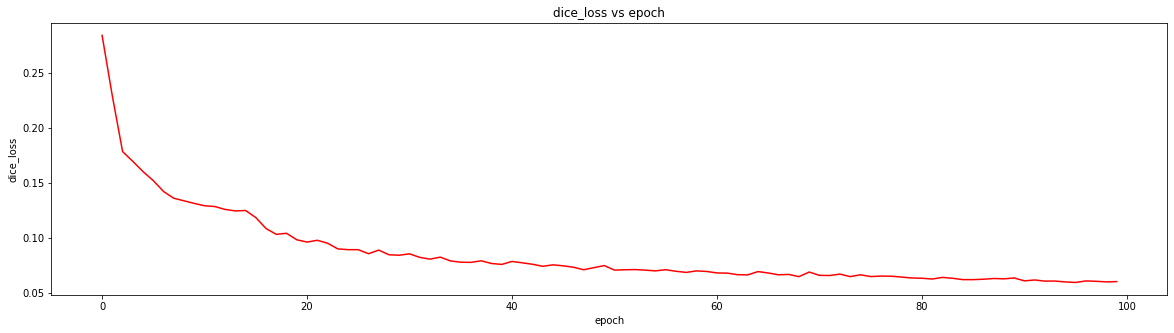

In [ ]:
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_dice.history['dice_loss'],color = 'Red')
plt.title('dice_loss vs epoch')
plt.ylabel('dice_loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

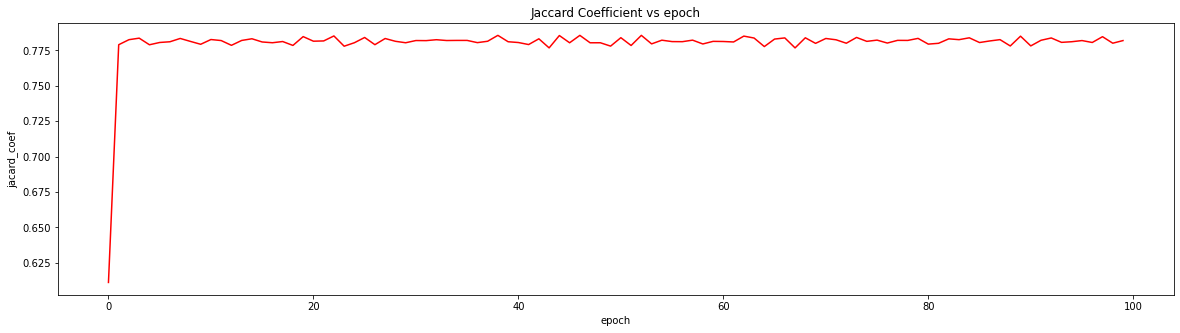

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_jaccard.history['jacard_coef'], color = 'Red')
plt.title('Jaccard Coefficient vs epoch')
plt.ylabel('jacard_coef')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

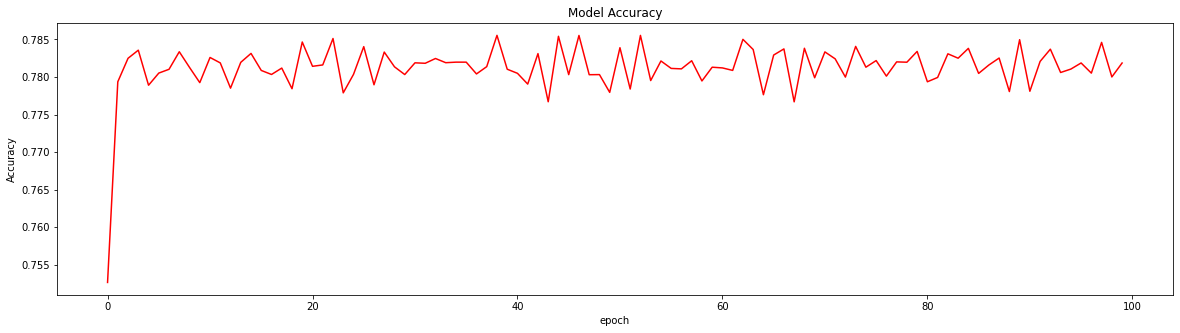

In [ ]:
plt.figure(figsize=(20,5))
#plt.subplot(1,2,1)
#plt.plot(history_dice.history['epochs'])
plt.plot(history_jaccard.history['accuracy'], color = 'Red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')